In [ ]:
# Import necessary libraries for our RAG application and teaching agent
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
import glob
import matplotlib.pyplot as plt  # For plotting graphs
import time  # For timing stages

print("Libraries imported successfully!")


# Step 1: Setup Environment and LLM
# This is like setting up your classroom with the right tools
def setup_environment():
    load_dotenv()
    if not os.getenv("GROQ_API_KEY"):
        raise ValueError("Please set GROQ_API_KEY in your .env file!")
    llm = ChatGroq(model="llama-3.3-70b-versatile")
    print("Environment setup complete. Your AI teacher is ready!")
    return llm


# Step 2: Load Documents from Any Code Folder
# Simplified version with optimized chunk size
import os
import glob
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import re

def generate_tree_structure(directory):
    """Generate a textual representation of the directory tree."""
    tree = []
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = '  ' * level
        tree.append(f"{indent}{os.path.basename(root)}/")
        for f in files:
            tree.append(f"{indent}  {f}")
    return "\n".join(tree)

def infer_code_flow(files, directory):
    """Basic inference of code flow by looking at imports/requires."""
    flow = []
    import_patterns = {
        'py': r"import\s+[\w.]+\s*(?:as\s+\w+)?|from\s+[\w.]+\s+import\s+[\w.*]+",
        'js': r"import\s+.*?\s+from\s+['\"].*?['\"]|require\(['\"].*?['\"]\)",
        'jsx': r"import\s+.*?\s+from\s+['\"].*?['\"]|require\(['\"].*?['\"]\)"
    }
    
    for file_path in files:
        ext = file_path.rsplit('.', 1)[-1] if '.' in file_path else ''
        if ext in import_patterns:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                imports = re.findall(import_patterns[ext], content)
                if imports:
                    rel_path = os.path.relpath(file_path, directory)
                    flow.append(f"{rel_path} depends on:")
                    for imp in imports:
                        flow.append(f"  - {imp.strip()}")
            except Exception as e:
                flow.append(f"Error analyzing {file_path}: {e}")
    return "\n".join(flow) if flow else "No detectable dependencies found."

def load_documents(directory="code_folder"):
    """Load code files, tree, and flow from the directory."""
    # Verify directory exists
    abs_dir = os.path.abspath(directory)
    if not os.path.isdir(abs_dir):
        print(f"Error: Directory '{abs_dir}' does not exist!")
        return []
    print(f"Scanning directory: {abs_dir}")

    # Define supported extensions
    extensions = ("py", "js", "jsx", "ts", "java", "c", "cpp", "cs", "go", "rs", 
                  "php", "rb", "sh", "txt", "md", "html", "css", "yaml", "yml", "conf")
    glob_pattern = "**/*.{" + ",".join(extensions) + "}"
    print(f"Using glob pattern: {glob_pattern}")

    # Find all matching files
    matching_files = []
    for ext in extensions:
        matching_files.extend(glob.glob(os.path.join(directory, f"**/*.{ext}"), recursive=True))
    print(f"Found {len(matching_files)} files:")
    for file in matching_files[:5]:
        print(f"  {file}")
    if len(matching_files) > 5:
        print(f"  ...and {len(matching_files) - 5} more")

    # Load documents
    documents = []
    for file_path in matching_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            doc = Document(page_content=content, metadata={"source": os.path.relpath(file_path, directory)})
            documents.append(doc)
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")

    # Add tree structure
    tree_content = generate_tree_structure(directory)
    documents.append(Document(page_content=tree_content, metadata={"source": "directory_tree.txt"}))

    # Add code flow
    flow_content = infer_code_flow(matching_files, directory)
    documents.append(Document(page_content=flow_content, metadata={"source": "code_flow.txt"}))

    # Debug: Count files per subfolder
    subfolders = set()
    for doc in documents:
        source = doc.metadata.get("source", "")
        if source not in ["directory_tree.txt", "code_flow.txt"]:
            subfolder = os.path.dirname(source)
            subfolders.add(subfolder if subfolder else "root")

    print(f"Loaded {len(documents)} files across {len(subfolders)} subfolders:")
    for subfolder in sorted(subfolders):
        if subfolder == "root":
            file_count = sum(1 for doc in documents 
                            if "/" not in doc.metadata.get("source", "") 
                            and doc.metadata["source"] not in ["directory_tree.txt", "code_flow.txt"])
        else:
            file_count = sum(1 for doc in documents 
                            if doc.metadata.get("source", "").startswith(subfolder + "/") 
                            and doc.metadata["source"] not in ["directory_tree.txt", "code_flow.txt"])
        if file_count > 0:
            print(f"  {subfolder}: {file_count} files")

    # Split into chunks with optimized size
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    split_docs = text_splitter.split_documents(documents)
    print(f"Loaded {len(documents)} files, split into {len(split_docs)} chunks")
    return split_docs


# Step 3: Create Vector Store
# This is like building a library index for quick reference
def create_vector_store(docs, persist_dir="./chroma_db"):
    embeddings = OllamaEmbeddings(
        model="mxbai-embed-large",
        # base_url="http://localhost:11434"  # Ensure Ollama is running
    )
    vector_store = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        persist_directory=persist_dir
    )
    print(f"Vector store created at {persist_dir}")
    return vector_store


# Step 4: Define Application State and Enhanced Agent
# This is the student's notebook, tracking progress through the development lifecycle
class AgentState(TypedDict):
    query: str
    documents: List[Document]
    response: str
    stage: str  # Track development stage (e.g., planning, coding, testing)
    test_results: List[bool]  # Store test outcomes


def teaching_agent(state: AgentState, llm):
    stages = ["Planning", "Coding", "Testing", "Deployment"]
    if "stage" not in state or not state["stage"]:
        state["stage"] = stages[0]  # Start with Planning
    
    context = "\n\n".join([doc.page_content for doc in state["documents"]]) if state["documents"] else ""
    
    prompt = f"""
    **Role**: You are an expert software architect and educator specializing in codebase analysis and explanation.
    
    **Current Development Stage**: {state['stage']}
    
    **User Query Analysis**:
    - Original query: "{state['query']}"
    - Interpreted intent: [Your interpretation of what the user really needs to know]
    
    **Code Context Analysis**:
    {context if context else "No relevant code context found"}
    
    **Task Requirements**:
    1. Architectural Breakdown:
       - Identify key components/modules in the codebase
       - Explain their relationships and data flow
       - Highlight any design patterns used
    
    2. Stage-Specific Guidance:
       {{
       "Planning": "Focus on overall architecture and requirements",
       "Coding": "Explain implementation details and best practices",
       "Testing": "Highlight testable components and suggest test cases",
       "Deployment": "Discuss deployment considerations and infrastructure"
       }}[{state['stage']}]
    
    3. User-Level Adaptation:
       - Assess the user's likely skill level based on their query
       - Adjust technical depth accordingly
       - Use analogies where helpful
    
    **Response Format**:
    - Start with 1-sentence summary
    - Then provide detailed breakdown
    - End with actionable next steps
    
    **Special Instructions**:
    - Never say "based on the context" or similar phrases
    - If information is incomplete, state what's missing
    - Use markdown formatting for code blocks and lists
    """
    
    response = llm.invoke(prompt)
    return {
        "response": response.content,
        "stage": state["stage"],
        "test_results": state.get("test_results", [])
    }

code_directory="otter-detection"
persist_dir="./chroma_db"
if not os.path.exists(persist_dir):
    docs = load_documents(code_directory)
    if docs:
        create_vector_store(docs, persist_dir)
    else:
        print("No code files found!")


from langchain.tools.retriever import create_retriever_tool

def load_chroma_retriever(persist_dir: str = "./chroma_db"):
    embeddings = OllamaEmbeddings(
        model="mxbai-embed-large",
    )

    vector_store = Chroma(
        persist_directory=persist_dir,
        embedding_function=embeddings
    )
    
    return vector_store.as_retriever()

# Initialize the retriever tool
retriever = load_chroma_retriever()
retriever_tool = create_retriever_tool(
    retriever,
    "codebase_retriever",
    "Search for information about the codebase architecture and implementation"
)



# Step 6: Build the Workflow
# This is the lesson plan, guiding you through the lifecycle
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
def build_workflow(llm):
    workflow = StateGraph(AgentState)
    
    # Modified retrieve node to maintain Document structure
    workflow.add_node("retrieve", lambda state: {
        "documents": [
            Document(page_content=content) 
            for content in retriever_tool.run(state["query"]).split("\n\n")  # Simple split, adjust as needed
        ]
    })
    
    # Rest of your workflow remains the same
    workflow.add_node("teach", lambda state: teaching_agent(state, llm))
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "teach")
    workflow.add_edge("teach", END)

    graph =  workflow.compile()
    display(Image(graph.get_graph().draw_mermaid_png()))
    
    return graph


llm = setup_environment()

app = build_workflow(llm)


# Step 7: Run the Application with Progress Tracking
def run_app(query: str):
    state = {"query": query, "test_results": []}
    stages_completed = []
    times = []
    start_time = time.time()

    state = app.invoke(state)
    stages_completed.append(state["stage"])
    times.append(time.time() - start_time)
    print(f"\nStage: {state['stage']}\nResponse: {state['response']}")

    return state, stages_completed, times


# Run with a sample query
query = "tell me about the react code in databse, how its working"
code_dir = "otter-detection"
final_state, stages, times = run_app(query)

In [16]:
# Import necessary libraries
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
import glob
import time
from duckduckgo_search import DDGS  # DuckDuckGo search library
import json  # For chat history storage
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

print("Libraries imported successfully!")

# Step 1: Setup Environment and LLM
def setup_environment():
    load_dotenv()
    if not os.getenv("GROQ_API_KEY"):
        raise ValueError("Please set GROQ_API_KEY in your .env file!")
    llm = ChatGroq(model="llama-3.3-70b-versatile")
    print("Environment setup complete. Your AI teacher is ready!")
    return llm

# Step 2: Load Documents from Codebase
def load_documents(directory="code_folder"):
    abs_dir = os.path.abspath(directory)
    if not os.path.isdir(abs_dir):
        print(f"Error: Directory '{abs_dir}' does not exist!")
        return []
    print(f"Scanning directory: {abs_dir}")
    extensions = ("py", "js", "jsx", "ts", "java", "c", "cpp", "cs", "go", "rs", 
                  "php", "rb", "sh", "txt", "md", "html", "css", "yaml", "yml", "conf")
    matching_files = [f for ext in extensions for f in glob.glob(os.path.join(directory, f"**/*.{ext}"), recursive=True)]
    documents = []
    for file_path in matching_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            doc = Document(page_content=content, metadata={"source": os.path.relpath(file_path, directory)})
            documents.append(doc)
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    split_docs = text_splitter.split_documents(documents)
    print(f"Loaded {len(documents)} files, split into {len(split_docs)} chunks")
    return split_docs

# Step 3: Create Vector Store
def create_vector_store(docs, persist_dir="./chroma_db"):
    embeddings = OllamaEmbeddings(model="mxbai-embed-large")
    vector_store = Chroma.from_documents(documents=docs, embedding=embeddings, persist_directory=persist_dir)
    print(f"Vector store created at {persist_dir}")
    return vector_store

# Step 4: Define Application State
class AgentState(TypedDict):
    query: str
    documents: List[Document]
    web_results: List[str]
    broken_queries: List[str]
    response: str
    example_code: str
    chat_history: List[dict]

# Step 5: Chat History Management
def load_chat_history(history_file="chat_history.json"):
    if os.path.exists(history_file):
        with open(history_file, 'r') as f:
            return json.load(f)
    return []

def save_chat_history(history, history_file="chat_history.json"):
    with open(history_file, 'w') as f:
        json.dump(history, f, indent=2)

# Step 6: Query Breaker
def break_query(query: str) -> List[str]:
    # Simple heuristic to break query into components
    keywords = query.lower().split()
    components = [word for word in keywords if word not in ("tell", "me", "about", "the", "in", "how", "its", "working")]
    return components

# Step 7: Web Search with DuckDuckGo
def web_search(query: str) -> List[str]:
    with DDGS() as ddgs:
        results = [r['body'] for r in ddgs.text(query, max_results=5)]
    return results

# Step 8: Teaching Agent
def teaching_agent(state: AgentState, llm):
    context = "\n\n".join([doc.page_content for doc in state["documents"]]) if state["documents"] else ""
    web_info = "\n\n".join(state["web_results"]) if state["web_results"] else "No web results found."
    
    prompt = f"""
    **Role**: You are an AI Code Assistant helping a user learn a codebase step-by-step.
    
    **User Query**: "{state['query']}"
    **Broken Down Components**: {state['broken_queries']}
    
    **Codebase Info**:
    {context if context else "No codebase info available."}
    
    **Web Resources**:
    {web_info}
    
    **Task**:
    1. Explain the codebase simply, focusing on components from the query.
    2. Adapt explanation to a beginner-to-intermediate level.
    3. Use analogies if helpful.
    
    **Response Format**:
    - 1-sentence summary
    - Detailed explanation of components
    - Next steps to practice
    """
    
    response = llm.invoke(prompt)
    return {"response": response.content}

# Step 9: AI Coder for Example Code
def ai_coder(state: AgentState, llm):
    context = "\n\n".join([doc.page_content for doc in state["documents"]]) if state["documents"] else ""
    components = state["broken_queries"]
    
    prompt = f"""
    **Role**: You are an AI Coder providing example code from the codebase.
    
    **User Query**: "{state['query']}"
    **Components**: {components}
    
    **Codebase**:
    {context}
    
    **Task**:
    - Find and extract example code related to {components} from the codebase.
    - If no exact match, say "No specific example found for {components}."
    
    **Format**:
    ```language
    [Code here]

    """

    response = llm.invoke(prompt)
    return {"example_code": response.content}

# Step 10: Build Workflow
def build_workflow(llm):
    workflow = StateGraph(AgentState)

    workflow.add_node("retrieve", lambda state: {"documents": load_documents("otter-detection")})
    workflow.add_node("break_query", lambda state: {"broken_queries": break_query(state["query"])})
    workflow.add_node("web_search", lambda state: {"web_results": web_search(state["query"])})
    workflow.add_node("teach", lambda state: teaching_agent(state, llm))
    workflow.add_node("code", lambda state: ai_coder(state, llm))

    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "break_query")
    workflow.add_edge("break_query", "web_search")
    workflow.add_edge("web_search", "teach")
    workflow.add_edge("teach", "code")
    workflow.add_edge("code", END)

    display(Image(workflow.compile().get_graph().draw_mermaid_png()))

    return workflow.compile()

# Step 11: Run Application
def run_app(query: str):
    chat_history = load_chat_history()

    state = {
    "query": query,
    "documents": [],
    "web_results": [],
    "broken_queries": [],
    "response": "",
    "example_code": "",
    "chat_history": chat_history
    }

    start_time = time.time()
    state = app.invoke(state)

    # Update and save chat history
    state["chat_history"].append({"query": query, "response": state["response"], "example_code": state["example_code"]})
    save_chat_history(state["chat_history"])

    print(f"\nTime taken: {time.time() - start_time:.2f}s")
    print(f"Response: {state['response']}")
    print(f"Example Code: {state['example_code']}")
    return state



Libraries imported successfully!


Environment setup complete. Your AI teacher is ready!


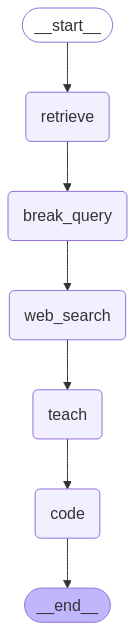

In [17]:
llm = setup_environment()
app = build_workflow(llm)


In [18]:
# # Run with sample query
# if name == "main":
query = "tell me about the react code in database, how its working"
run_app(query)

Scanning directory: /home/saurabh-nitro/projects/AgenticAI/CodeExplorerRAG/otter-detection
Loaded 71 files, split into 1068 chunks


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama-3.3-70b-versatile` in organization `org_01jkn17ndxemn94rs4e3dy9qj3` service tier `on_demand` on tokens per day (TPD): Limit 100000, Requested 439902, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:

# Import necessary libraries
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
import glob
import time
from langchain_community.tools import DuckDuckGoSearchRun
import json
from IPython.display import Image, display
import requests  # For error handling

print("Libraries imported successfully!")

# Step 1: Setup Environment and LLM
def setup_environment():
    load_dotenv()
    if not os.getenv("GROQ_API_KEY"):
        raise ValueError("Please set GROQ_API_KEY in your .env file!")
    llm = ChatGroq(model="llama-3.3-70b-versatile")
    print("Environment setup complete. Your AI teacher is ready!")
    return llm

# Step 2: Load Documents from Codebase
def load_documents(directory="code_folder"):
    abs_dir = os.path.abspath(directory)
    if not os.path.isdir(abs_dir):
        print(f"Error: Directory '{abs_dir}' does not exist!")
        return []
    print(f"Scanning directory: {abs_dir}")
    extensions = ("py", "js", "jsx", "ts", "java", "c", "cpp", "cs", "go", "rs", 
                  "php", "rb", "sh", "txt", "md", "html", "css", "yaml", "yml", "conf")
    matching_files = [f for ext in extensions for f in glob.glob(os.path.join(directory, f"**/*.{ext}"), recursive=True)]
    documents = []
    for file_path in matching_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            doc = Document(page_content=content, metadata={"source": os.path.relpath(file_path, directory)})
            documents.append(doc)
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    split_docs = text_splitter.split_documents(documents)
    print(f"Loaded {len(documents)} files, split into {len(split_docs)} chunks")
    return split_docs

# Step 3: Create Vector Store
def create_vector_store(docs, persist_dir="./chroma_db"):
    embeddings = OllamaEmbeddings(model="mxbai-embed-large")
    vector_store = Chroma.from_documents(documents=docs, embedding=embeddings, persist_directory=persist_dir)
    print(f"Vector store created at {persist_dir}")
    return vector_store

# Step 4: Define Application State
class AgentState(TypedDict):
    query: str
    documents: List[Document]
    web_results: str
    broken_queries: List[str]
    response: str
    example_code: str
    chat_history: List[dict]

# Step 5: Chat History Management
def load_chat_history(history_file="chat_history.json"):
    if os.path.exists(history_file):
        with open(history_file, 'r') as f:
            return json.load(f)
    return []

def save_chat_history(history, history_file="chat_history.json"):
    with open(history_file, 'w') as f:
        json.dump(history, f, indent=2)

# Step 6: Query Breaker
def break_query(query: str) -> List[str]:
    keywords = query.lower().split()
    components = [word for word in keywords if word not in ("tell", "me", "about", "the", "in", "how", "its", "working")]
    return components

# Step 7: Web Search with DuckDuckGoSearchRun
def web_search(query: str) -> str:
    try:
        search = DuckDuckGoSearchRun()
        return search.invoke(query)
    except Exception as e:
        print(f"Web search failed: {e}")
        return "Web search unavailable."

# Step 8: Teaching Agent
def teaching_agent(state: AgentState, llm):
    context = "\n\n".join([doc.page_content for doc in state["documents"]]) if state["documents"] else ""
    web_info = state["web_results"] if state["web_results"] else "No web results found."
    
    prompt = f"""
    **Role**: You are an AI Code Assistant helping a user learn a codebase step-by-step.
    
    **User Query**: "{state['query']}"
    **Broken Down Components**: {state['broken_queries']}
    
    **Codebase Info**:
    {context if context else "No codebase info available."}
    
    **Web Resources**:
    {web_info}
    
    **Task**:
    1. Explain the codebase simply, focusing on components from the query.
    2. Adapt explanation to a beginner-to-intermediate level.
    3. Use analogies if helpful.
    
    **Response Format**:
    - 1-sentence summary
    - Detailed explanation of components
    - Next steps to practice
    """
    
    response = llm.invoke(prompt)
    return {"response": response.content}

# Step 9: AI Coder for Example Code
def ai_coder(state: AgentState, llm):
    context = "\n\n".join([doc.page_content for doc in state["documents"]]) if state["documents"] else ""
    components = state["broken_queries"]
    
    prompt = f"""
    **Role**: You are an AI Coder providing example code from the codebase.
    
    **User Query**: "{state['query']}"
    **Components**: {components}
    
    **Codebase**:
    {context}
    
    **Task**:
    - Find and extract example code related to {components} from the codebase.
    - If no exact match, say "No specific example found for {components}."
    
    **Format**:
    ```language
    [Code here]
    ```
    """
    
    response = llm.invoke(prompt)
    return {"example_code": response.content}

# Step 10: Build Workflow
def build_workflow(llm):
    workflow = StateGraph(AgentState)
    
    workflow.add_node("retrieve", lambda state: {"documents": load_documents("otter-detection")})
    workflow.add_node("break_query", lambda state: {"broken_queries": break_query(state["query"])})
    workflow.add_node("web_search", lambda state: {"web_results": web_search(state["query"])})
    workflow.add_node("teach", lambda state: teaching_agent(state, llm))
    workflow.add_node("code", lambda state: ai_coder(state, llm))
    
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "break_query")
    workflow.add_edge("break_query", "web_search")
    workflow.add_edge("web_search", "teach")
    workflow.add_edge("teach", "code")
    workflow.add_edge("code", END)
    
    graph = workflow.compile()
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Skip graph display to avoid timeout
    print("Workflow compiled successfully. Graph display skipped to avoid timeout.")
    # Optional: Uncomment to attempt graph display with error handling
    # try:
    #     display(Image(graph.get_graph().draw_mermaid_png()))
    # except Exception as e:
    #     print(f"Failed to display graph: {e}")
    
    return graph



In [ ]:
llm = setup_environment()

In [ ]:
app = build_workflow(llm)

In [ ]:
# Step 11: Run Application
def run_app(query: str):

    chat_history = load_chat_history()
    
    state = {
        "query": query,
        "documents": [],
        "web_results": "",
        "broken_queries": [],
        "response": "",
        "example_code": "",
        "chat_history": chat_history
    }
    
    start_time = time.time()
    state = app.invoke(state)
    
    # Update and save chat history
    state["chat_history"].append({"query": query, "response": state["response"], "example_code": state["example_code"]})
    save_chat_history(state["chat_history"])
    
    print(f"\nTime taken: {time.time() - start_time:.2f}s")
    print(f"Response: {state['response']}")
    print(f"Example Code: {state['example_code']}")
    return state

In [ ]:
# # Run with sample query
# if __name__ == "__main__":
query = "tell me about the react code in database, how its working"
run_app(query)

In [ ]:

# Import necessary libraries
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
import glob
import time
from langchain_community.tools import DuckDuckGoSearchRun
import json
from IPython.display import Image, display
import requests
from groq import APIStatusError
import re

print("Libraries imported successfully!")

# Step 1: Setup Environment and LLM
def setup_environment():
    load_dotenv()
    if not os.getenv("GROQ_API_KEY"):
        raise ValueError("Please set GROQ_API_KEY in your .env file!")
    llm = ChatGroq(model="llama3-70b-8192")
    print("Environment setup complete. Your AI teacher is ready!")
    return llm

# Step 2: Load Documents with Tree Structure and Code Flow
def generate_tree_structure(directory):
    tree = []
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = '  ' * level
        tree.append(f"{indent}{os.path.basename(root)}/")
        for f in files:
            tree.append(f"{indent}  {f}")
    return "\n".join(tree)

def infer_code_flow(files, directory):
    flow = []
    import_patterns = {
        'py': r"import\s+[\w.]+\s*(?:as\s+\w+)?|from\s+[\w.]+\s+import\s+[\w.*]+",
        'js': r"import\s+.*?\s+from\s+['\"].*?['\"]|require\(['\"].*?['\"]\)",
        'jsx': r"import\s+.*?\s+from\s+['\"].*?['\"]|require\(['\"].*?['\"]\)"
    }
    for file_path in files:
        ext = file_path.rsplit('.', 1)[-1] if '.' in file_path else ''
        if ext in import_patterns:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                imports = re.findall(import_patterns[ext], content)
                if imports:
                    rel_path = os.path.relpath(file_path, directory)
                    flow.append(f"{rel_path} depends on:")
                    for imp in imports:
                        flow.append(f"  - {imp.strip()}")
            except Exception as e:
                flow.append(f"Error analyzing {file_path}: {e}")
    return "\n".join(flow) if flow else "No detectable dependencies found."

def load_documents(directory="code_folder"):
    abs_dir = os.path.abspath(directory)
    if not os.path.isdir(abs_dir):
        print(f"Error: Directory '{abs_dir}' does not exist!")
        return []
    print(f"Scanning directory: {abs_dir}")
    extensions = ("py", "js", "jsx", "ts", "java", "c", "cpp", "cs", "go", "rs", 
                  "php", "rb", "sh", "txt", "md", "html", "css", "yaml", "yml", "conf")
    matching_files = [f for ext in extensions for f in glob.glob(os.path.join(directory, f"**/*.{ext}"), recursive=True)]
    documents = []
    for file_path in matching_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            doc = Document(page_content=content, metadata={"source": os.path.relpath(file_path, directory)})
            documents.append(doc)
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
    
    # Add tree structure and code flow as documents
    tree_content = generate_tree_structure(directory)
    documents.append(Document(page_content=tree_content, metadata={"source": "directory_tree.txt"}))
    flow_content = infer_code_flow(matching_files, directory)
    documents.append(Document(page_content=flow_content, metadata={"source": "code_flow.txt"}))

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
    split_docs = text_splitter.split_documents(documents)
    print(f"Loaded {len(documents)} files, split into {len(split_docs)} chunks")
    return split_docs

# Step 3: Create Vector Store
def create_vector_store(docs, persist_dir="./chroma_db"):
    embeddings = OllamaEmbeddings(model="mxbai-embed-large")
    vector_store = Chroma.from_documents(documents=docs, embedding=embeddings, persist_directory=persist_dir)
    print(f"Vector store created at {persist_dir}")
    return vector_store

# Step 4: Define Application State
class AgentState(TypedDict):
    query: str
    documents: List[Document]
    filtered_documents: List[Document]  # Added for similarity search results
    web_results: str
    broken_queries: List[str]
    response: str
    example_code: str
    chat_history: List[dict]
    feedback: dict

# Step 5: Chat History Management (unchanged)
def load_chat_history(history_file="chat_history.json"):
    if os.path.exists(history_file):
        with open(history_file, 'r') as f:
            return json.load(f)
    return []

def save_chat_history(history, history_file="chat_history.json"):
    with open(history_file, 'w') as f:
        json.dump(history, f, indent=2)

# Step 6: Initial Agent for Analysis and Similarity Search
def initial_agent(state: AgentState, llm, vector_store):
    query = state["query"]
    documents = state["documents"]
    
    # Extract tree structure and code flow from documents
    tree_doc = next((doc for doc in documents if doc.metadata["source"] == "directory_tree.txt"), None)
    flow_doc = next((doc for doc in documents if doc.metadata["source"] == "code_flow.txt"), None)
    
    tree_content = tree_doc.page_content if tree_doc else ""
    flow_content = flow_doc.page_content if flow_doc else ""
    
    # Generate keywords from query, tree, and flow
    query_keywords = query.lower().split()
    tree_keywords = set(re.findall(r"\w+", tree_content.lower()))
    flow_keywords = set(re.findall(r"\w+", flow_content.lower()))
    combined_keywords = " ".join(set(query_keywords) & (tree_keywords | flow_keywords)) or query
    
    # Perform similarity search
    try:
        filtered_docs = vector_store.similarity_search(combined_keywords, k=5)  # Limit to 5 most relevant docs
        if not filtered_docs:
            return {"filtered_documents": [], "feedback": {"step": "initial", "status": "failed", "message": "No relevant documents found"}}
        return {"filtered_documents": filtered_docs, "feedback": {"step": "initial", "status": "success"}}
    except Exception as e:
        print(f"Similarity search failed: {e}")
        return {"filtered_documents": [], "feedback": {"step": "initial", "status": "failed", "message": str(e)}}

# Step 7: Query Breaker with Check (unchanged)
def break_query(state: AgentState):
    keywords = state["query"].lower().split()
    components = [word for word in keywords if word not in ("tell", "me", "about", "the", "in", "how", "its", "working")]
    if not components:
        return {"broken_queries": [], "feedback": {"step": "break_query", "status": "failed", "message": "No meaningful components extracted"}}
    return {"broken_queries": components, "feedback": {"step": "break_query", "status": "success"}}

# Step 8: Web Search with Check and Retry (unchanged)
def web_search(state: AgentState):
    try:
        search = DuckDuckGoSearchRun()
        result = search.invoke(state["query"])
        if not result or result.strip() == "":
            return {"web_results": "", "feedback": {"step": "web_search", "status": "retry", "message": "Empty web results"}}
        return {"web_results": result, "feedback": {"step": "web_search", "status": "success"}}
    except Exception as e:
        print(f"Web search failed: {e}")
        return {"web_results": "Web search unavailable", "feedback": {"step": "web_search", "status": "retry", "message": str(e)}}


def teach_to_code(state: AgentState, llm):
    context = "\n\n".join([doc.page_content for doc in state["filtered_documents"]]) if state["filtered_documents"] else "No relevant codebase info found."
    web_info = state["web_results"][:2000] if state["web_results"] else "No web results found."
    
    prompt = f"""
    **Role**: You are an AI Code Assistant instructing an AI Coder to generate detailed, beginner-friendly code.

    **User Query**: "{state['query']}"
    **Broken Down Components**: {state['broken_queries']}
    
    **Codebase Info (filtered)**:
    {context}
    
    **Web Resources**:
    {web_info}
    
    **Task**:
    - Provide clear, step-by-step instructions for the AI Coder to create example code that fully addresses the query.
    - Ensure the code is:
      1. Relevant to the query components ({state['broken_queries']}).
      2. Beginner-friendly with explanatory comments.
      3. Functional and based on the filtered codebase or web resources.
      4. Well-structured with at least one practical example.
    - Do not write the code yourself; focus on guiding the coder.

    **Response Format**:
    - Instructions:
      1. [Step 1: What to do]
      2. [Step 2: What to include]
      3. [Step 3: Specific guidance]

    """
    
    try:
        response = llm.invoke(prompt)
        if not response.content.strip():
            return {"response": "", "feedback": {"step": "teach_to_code", "status": "failed", "message": "Empty response from teach_to_code"}}
        return {"response": response.content, "feedback": {"step": "teach_to_code", "status": "success"}}
    except APIStatusError as e:
        print(f"API Error: {e.response.text}")
        return {"response": "", "feedback": {"step": "teach_to_code", "status": "failed", "message": f"API error: {e.response.text}"}}


def ai_coder(state: AgentState, llm):
    context = "\n\n".join([doc.page_content for doc in state["filtered_documents"]]) if state["filtered_documents"] else "No relevant codebase info found."
    components = state["broken_queries"]
    teach_instructions = state["response"]  # Instructions from teach_to_code
    
    prompt = f"""
    **Role**: You are an AI Coder generating detailed, beginner-friendly code based on precise instructions.

    **User Query**: "{state['query']}"
    **Components**: {components}
    
    **Instructions from Teacher**:
    {teach_instructions}
    
    **Codebase (filtered)**:
    {context}
    
    **Task**:
    - Follow the teacher's instructions exactly to generate functional code.
    - Ensure the code is:
      1. Relevant to the query and components.
      2. Well-commented for beginners (explain each major step).
      3. Includes a practical example demonstrating the functionality.
    - If no match is found, say "No specific example found for {components}" with a brief explanation.

    **Response Format**:
    - Code:
      ```language
      [Detailed code with comments]
      ```
    - Breakdown:
      1. [Point 1: What this part does]
      2. [Point 2: Why it’s included]
      ...

    """
    
    try:
        response = llm.invoke(prompt)
        if "No specific example found" in response.content or not response.content.strip():
            return {"example_code": response.content, "feedback": {"step": "code", "status": "partial", "message": "Limited or no code examples found"}}
        return {"example_code": response.content, "feedback": {"step": "code", "status": "success"}}
    except APIStatusError as e:
        print(f"API Error: {e.response.text}")
        return {"example_code": "", "feedback": {"step": "code", "status": "failed", "message": f"API error: {e.response.text}"}}

def verify_code(state: AgentState, llm):
    example_code = state["example_code"]
    context = "\n\n".join([doc.page_content for doc in state["filtered_documents"]]) if state["filtered_documents"] else "No relevant codebase info found."
    
    prompt = f"""
    **Role**: You are an AI Code Verifier ensuring the generated code is correct and functional.

    **User Query**: "{state['query']}"
    **Generated Code Example**:
    {example_code}
    
    **Codebase Info (filtered)**:
    {context}
    
    **Task**:
    - Verify the code for:
      1. Syntax correctness.
      2. Relevance to the query.
      3. Functionality (would it work as intended?).
    - If issues are found, suggest specific fixes with examples.
    - If correct, confirm with a detailed validation.

    **Response Format**:
    - Result: [“Code verified successfully” or “Code verification failed”]
    - Details:
      1. [Point 1: Syntax check]
      2. [Point 2: Relevance check]
      3. [Point 3: Functionality check]
    - Fixed Code (if applicable)
    """
    
    try:
        response = llm.invoke(prompt)
        verified_code = response.content.strip()
        if "Code verification failed" in verified_code:
            return {"example_code": verified_code, "feedback": {"step": "verify_code", "status": "failed", "message": "Code verification failed"}}
        return {"example_code": verified_code, "feedback": {"step": "verify_code", "status": "success"}}
    except APIStatusError as e:
        print(f"API Error: {e.response.text}")
        return {"example_code": example_code, "feedback": {"step": "verify_code", "status": "failed", "message": f"API error: {e.response.text}"}}

def teach_final(state: AgentState, llm):
    context = "\n\n".join([doc.page_content for doc in state["filtered_documents"]]) if state["filtered_documents"] else "No relevant codebase info found."
    web_info = state["web_results"][:2000] if state["web_results"] else "No web results found."
    example_code = state["example_code"]  # Verified code from verify_code
    
    prompt = f"""
    **Role**: You are an AI Code Assistant providing an in-depth, point-wise explanation of the generated code.

    **User Query**: "{state['query']}"
    **Broken Down Components**: {state['broken_queries']}
    
    **Codebase Info (filtered)**:
    {context}
    
    **Web Resources**:
    {web_info}
    
    **Verified Code Example**:
    {example_code}
    
    **Task**:
    - Deliver a detailed explanation that:
      1. Summarizes how the code solves the query in one sentence.
      2. Breaks down the code into numbered points, each explaining a key part with:
         - What it does.
         - Why it’s important.
         - An analogy or example for clarity.
      3. Suggests next steps with practical examples for learning.

    **Response Format**:
    - Summary: [One-sentence summary]
    - Explanation:
      1. [Part 1: Description, purpose, analogy/example]
      2. [Part 2: Description, purpose, analogy/example]
      ...
    - Next Steps:
      1. [Step 1: What to try]
      2. [Step 2: How to extend]
    """
    
    try:
        response = llm.invoke(prompt)
        if not response.content.strip():
            return {"response": "", "feedback": {"step": "teach_final", "status": "failed", "message": "Empty response from teach_final"}}
        return {"response": response.content, "feedback": {"step": "teach_final", "status": "success"}}
    except APIStatusError as e:
        print(f"API Error: {e.response.text}")
        return {"response": "", "feedback": {"step": "teach_final", "status": "failed", "message": f"API error: {e.response.text}"}}


def setup_agent(state: AgentState, llm):
    example_code = state["example_code"]
    query = state["query"]
    
    prompt = f"""
    **Role**: You are an AI Setup Assistant providing detailed, beginner-friendly instructions to run the generated code.

    **User Query**: "{state['query']}"
    **Generated Code Example**:
    {example_code}
    
    **Task**:
    First Create file tree arrangement with proper file names 
    - Create a step-by-step guide for a beginner to:
      1. create requirements.txt and detailed README.md.
      2. Use Docker and docker-compose if applicable.
      3. provide code environment details.
    - Include:
      - Prerequisites (e.g., tools to install).
      - Exact commands with explanations.
      - Example Dockerfile and docker-compose.yml with comments.

    Provide complete code setup.
    """
    
    try:
        response = llm.invoke(prompt)
        if not response.content.strip():
            return {"setup_instructions": "", "feedback": {"step": "setup", "status": "failed", "message": "Empty response from setup agent"}}
        return {"setup_instructions": response.content, "feedback": {"step": "setup", "status": "success"}}
    except APIStatusError as e:
        print(f"API Error: {e.response.text}")
        return {"setup_instructions": "", "feedback": {"step": "setup", "status": "failed", "message": f"API error: {e.response.text}"}}


def aggregator(state: AgentState):
    """Combine and format the final output from all steps"""
    # Initialize sections with empty strings
    sections = {
        "teaching_instructions": "",
        "verified_code": "",
        "setup_instructions": "",
        "final_explanation": ""
    }
    
    # Safely get each section if it exists in state
    if 'response' in state and state.get('feedback', {}).get('step') == 'teach_to_code':
        sections["teaching_instructions"] = state['response']
    
    if 'example_code' in state:
        sections["verified_code"] = state['example_code']
    
    if 'setup_instructions' in state:
        sections["setup_instructions"] = state['setup_instructions']
    
    if 'response' in state and state.get('feedback', {}).get('step') == 'teach_final':
        sections["final_explanation"] = state['response']
    
    # Build the combined output
    combined = f"=== Complete Response for: {state['query']} ===\n\n"
    combined += f"1. TEACHING INSTRUCTIONS:\n{sections['teaching_instructions']}\n\n" if sections['teaching_instructions'] else ""
    combined += f"2. VERIFIED CODE:\n{sections['verified_code']}\n\n" if sections['verified_code'] else ""
    combined += f"3. SETUP INSTRUCTIONS:\n{sections['setup_instructions']}\n\n" if sections['setup_instructions'] else ""
    combined += f"4. FINAL EXPLANATION:\n{sections['final_explanation']}\n" if sections['final_explanation'] else ""
    
    return {"combined_output": combined}


def build_workflow(llm, vector_store):
    workflow = StateGraph(AgentState)
    
    def retrieve_with_check(state):
        docs = load_documents("otter-detection")
        if not docs:
            return {"documents": [], "feedback": {"step": "retrieve", "status": "failed", "message": "No documents loaded"}}
        return {"documents": docs, "feedback": {"step": "retrieve", "status": "success"}}
    
    workflow.add_node("retrieve", retrieve_with_check)
    workflow.add_node("initial", lambda state: initial_agent(state, llm, vector_store))
    workflow.add_node("break_query", break_query)
    workflow.add_node("web_search", web_search)
    workflow.add_node("teach_to_code", lambda state: teach_to_code(state, llm))
    workflow.add_node("code", lambda state: ai_coder(state, llm))
    workflow.add_node("verify_code", lambda state: verify_code(state, llm))
    workflow.add_node("setup", lambda state: setup_agent(state, llm))
    workflow.add_node("teach_final", lambda state: teach_final(state, llm))
    workflow.add_node("aggregator", aggregator)
    
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "initial")
    workflow.add_edge("initial", "break_query")
    workflow.add_edge("break_query", "web_search")
    workflow.add_edge("web_search", "teach_to_code")
    workflow.add_edge("teach_to_code", "code")
    workflow.add_edge("code", "verify_code")
    workflow.add_edge("verify_code", "setup")
    workflow.add_edge("setup", "teach_final")
    workflow.add_edge("teach_final", "aggregator")
    workflow.add_edge("aggregator", END)
    
    graph = workflow.compile()
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("Workflow compiled successfully. Graph display skipped to avoid timeout.")
    return graph

Libraries imported successfully!


Environment setup complete. Your AI teacher is ready!


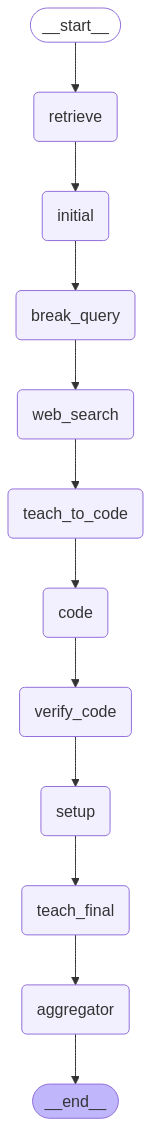

Workflow compiled successfully. Graph display skipped to avoid timeout.


In [74]:
llm = setup_environment()
# Load or create vector store
persist_dir = "./chroma_db"
if not os.path.exists(persist_dir):
    docs = load_documents("otter-detection")
    if docs:
        vector_store = create_vector_store(docs, persist_dir)
    else:
        raise ValueError("No documents loaded to create vector store")
else:
    embeddings = OllamaEmbeddings(model="mxbai-embed-large")
    vector_store = Chroma(persist_directory=persist_dir, embedding_function=embeddings)

app = build_workflow(llm, vector_store)

In [67]:
# Step 13: Run Application
def run_app(query: str):

    chat_history = load_chat_history()
    
    state = {
        "query": query,
        "documents": [],
        "filtered_documents": [],
        "web_results": "",
        "broken_queries": [],
        "response": "",
        "example_code": "",
        "chat_history": chat_history,
        "feedback": {}
    }
    
    start_time = time.time()
    state = app.invoke(state)
    
    state["chat_history"].append({"query": query, "response": state["response"], "example_code": state["example_code"]})
    save_chat_history(state["chat_history"])
    
    print(f"\nTime taken: {time.time() - start_time:.2f}s")
    # print(f"Response: {state['response']}")
    # print(f"Example Code: {state['example_code']}")
    return state


In [68]:

query = "How to develop simple video streaming app using python tornado api websocker based bcakend with React JS frontend web Streaming. Write end to end code with proper explaination. refer docs"
run_app(query)

Scanning directory: /home/saurabh-nitro/projects/AgenticAI/CodeExplorerRAG/otter-detection
Loaded 73 files, split into 1076 chunks

Time taken: 103.91s


{'query': 'How to develop simple video streaming app using python tornado api websocker based bcakend with React JS frontend web Streaming. Write end to end code with proper explaination. refer docs',
 'documents': [Document(metadata={'source': 'src/main.py'}, page_content='from decoder import decode_video\nfrom time import sleep\nfrom infer import get_input_shape, Engine\nfrom yolo import decode_yolo\nfrom server import Server, broadcast_tegrastats\nfrom hikvision import ptz, start_time_sync_loop\nfrom analyse import DetectionAnalyser\n\nstart_time_sync_loop()\n\nengine_path = "/engines/20250301_best_1280x704_int8.engine"\n# engine_path = "/engines/20250207_best_1280x704_int8.engine"\n# engine_path = "/engines/yolov7-w6_960_int8.engine"\n(_, _, input_height, input_width), *_ = get_input_shape(engine_path)\ndetection_engine = Engine(engine_path)\n\n\ndef client_message_callback(client, message):\n    if "pan" in message or "tilt" in message or "zoom" in message:\n        try:\n        

In [ ]:
# Setup environment (assuming this is defined elsewhere)
llm = setup_environment()
persist_dir = "./chroma_db"
if not os.path.exists(persist_dir):
    docs = load_documents("otter-detection")
    if docs:
        vector_store = create_vector_store(docs, persist_dir)
    else:
        raise ValueError("No documents loaded to create vector store")
else:
    embeddings = OllamaEmbeddings(model="mxbai-embed-large")
    vector_store = Chroma(persist_directory=persist_dir, embedding_function=embeddings)

# Build the workflow (assuming build_workflow is defined)
app = build_workflow(llm, vector_store)

In [69]:
# Step 13: Run Application with Streaming
def run_app(query: str):

    
    # Load chat history
    chat_history = load_chat_history()
    
    # Initial state
    state = {
        "query": query,
        "documents": [],
        "filtered_documents": [],
        "web_results": "",
        "broken_queries": [],
        "response": "",
        "example_code": "",
        "setup_instructions": "",  # Added from previous updates
        "chat_history": chat_history,
        "feedback": {}
    }
    
    start_time = time.time()
    print(f"\nStreaming responses for query: '{query}'...")
    
    # Stream the workflow's output
    for chunk in app.stream(state, stream_mode="values"):
        # Print intermediate results based on the current node’s output
        if "response" in chunk and chunk["response"]:
            print(f"\n[Teach to Code Instructions]:\n{chunk['response']}")
        if "example_code" in chunk and chunk["example_code"]:
            print(f"\n[Generated Code]:\n{chunk['example_code']}")
        if "setup_instructions" in chunk and chunk["setup_instructions"]:
            print(f"\n[Setup Instructions]:\n{chunk['setup_instructions']}")
        # Update state with the latest chunk
        state = chunk
    
    # Finalize chat history with the complete state
    state["chat_history"].append({
        "query": query,
        "response": state["response"],
        "example_code": state["example_code"],
        "setup_instructions": state.get("setup_instructions", "")
    })
    save_chat_history(state["chat_history"])
    
    print(f"\nTime taken: {time.time() - start_time:.2f}s")
    return state



In [70]:

query = "How to develop simple video streaming app using python tornado api websocker based bcakend with React JS frontend web Streaming. Write end to end code with proper explaination. refer docs"
run_app(query)


Streaming responses for query: 'How to develop simple video streaming app using python tornado api websocker based bcakend with React JS frontend web Streaming. Write end to end code with proper explaination. refer docs'...
Scanning directory: /home/saurabh-nitro/projects/AgenticAI/CodeExplorerRAG/otter-detection
Loaded 73 files, split into 1076 chunks

[Teach to Code Instructions]:
Here are the instructions for the AI Coder to create the example code:

**Task:** Develop a simple video streaming app using Python Tornado API with WebSocket-based backend and React JS frontend for web streaming.

**Step 1: Set up the project structure**
Create a new directory for the project and create the following subdirectories: `backend` and `frontend`. In the `backend` directory, create a new file called `app.py`. In the `frontend` directory, create a new file called `index.js` and a new directory called `components`.

**Step 2: Implement the backend using Tornado**
In `app.py`, import the necessary

{'query': 'How to develop simple video streaming app using python tornado api websocker based bcakend with React JS frontend web Streaming. Write end to end code with proper explaination. refer docs',
 'documents': [Document(metadata={'source': 'src/main.py'}, page_content='from decoder import decode_video\nfrom time import sleep\nfrom infer import get_input_shape, Engine\nfrom yolo import decode_yolo\nfrom server import Server, broadcast_tegrastats\nfrom hikvision import ptz, start_time_sync_loop\nfrom analyse import DetectionAnalyser\n\nstart_time_sync_loop()\n\nengine_path = "/engines/20250301_best_1280x704_int8.engine"\n# engine_path = "/engines/20250207_best_1280x704_int8.engine"\n# engine_path = "/engines/yolov7-w6_960_int8.engine"\n(_, _, input_height, input_width), *_ = get_input_shape(engine_path)\ndetection_engine = Engine(engine_path)\n\n\ndef client_message_callback(client, message):\n    if "pan" in message or "tilt" in message or "zoom" in message:\n        try:\n        